In [2]:
#|default_exp conv

## Convolutions

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from torch import nn

from torch.utils.data import DataLoader,default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

## Get data

In [5]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_to_data = Path('/Users/johnrichmond/datasets') / Path('data')
path_to_data.mkdir(exist_ok=True)
path_gz = path_to_data / 'mnist.pkg.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [6]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [7]:
# MAke the images a bit larger
mpl.rcParams['figure.dpi'] = 30

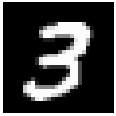

In [8]:
im3 = x_imgs[7]
_ = show_image(im3)

## Explore kernels 

In [9]:
k_top_edge = torch.tensor([
                          [-1,-1,-1],
                          [0, 0, 0],
                          [1, 1, 1]]).float()

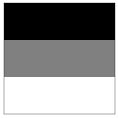

In [10]:
show_image(k_top_edge, with_frame=True);

The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$.

Take a corner of the image and put into a dataframe

In [11]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


Compare the values at the top edge of the three and at the bottom edge of the three

In [12]:
(im3[3:6,14:17] * k_top_edge).sum(), (im3[7:10,14:17] * k_top_edge).sum()

(tensor(2.9727), tensor(-2.9570))

Create a function to apply a kernal from a specific starting point

In [13]:
def apply_kernal(row, col, kernal):
    return (im3[row-1: row+2, col-1: col+2] * kernal).sum()

In [14]:
apply_kernal(4, 15, k_top_edge)

tensor(2.9727)

Now apply the kernal over the image and plot the result

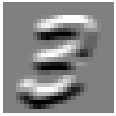

In [15]:
rng = range(1, im3.shape[0] -1)
output_top_edge = tensor([[apply_kernal(i, j, k_top_edge) for j in rng] for i in rng]) 
_ = show_image(output_top_edge)

The same can be done for other kernals

### Convolutions in PyTorch

In [16]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://hal.inria.fr/inria-00112631/).

![image.png](attachment:image.png)

Here's a sample [numpy implementation](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).

The next part of the course notebook looks at convolutions using im2col.  To save time this is left for now and I will move straight onto the applicaion of pytorch convolutions

In [17]:
k_diag1_edge = tensor([[0, -1, 1],
                    [-1, 1, 0],
                    [1, 0, 0]]).float()

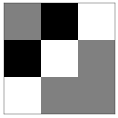

In [18]:
show_image(k_diag1_edge, with_frame=True);

In [19]:
k_diag2_edge = tensor([[0, 1, -1],
                     [1, -1, 0],
                     [-1, 0, 0]]).float()

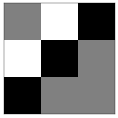

In [20]:
show_image(k_diag2_edge, with_frame=True);

In [21]:
k_left_edge = torch.tensor([
                          [-1, 1, 0],
                          [-1, 1, 0],
                          [-1, 1, 0]]).float()

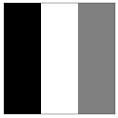

In [22]:
show_image(k_left_edge, with_frame=True);

Stack the kernals and apply them to a batch of images

In [23]:
edge_kernels = torch.stack([k_diag1_edge, k_diag2_edge, k_left_edge, k_top_edge])

In [24]:
edge_kernels.shape

torch.Size([4, 3, 3])

In [25]:
#Load a batch of images to process.  
# Add an additional dimension to represent the channel, which needs to be after the batch dimension
# also note that [:, None, :, :] is equivalent to[:, None], since the other dimensions are applied by default
xb = x_imgs[:16][:, None, :, :]
xb.shape

torch.Size([16, 1, 28, 28])

In [26]:
# Add another dimension to the kernal array to facilitate batch operation
edge_kernels = edge_kernels[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [27]:
batch_features = F.conv2d(xb, weight=edge_kernels)

In [28]:
batch_features.shape

torch.Size([16, 4, 26, 26])

Since no padding has been applied one pixel has been lost all of the way around the boundary.

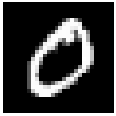

In [29]:
img0 = xb[1, 0]
show_image(img0);

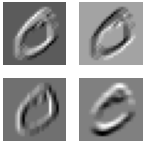

In [30]:
# show how this is seen by each of the filters
show_images([batch_features[1, i] for i in range(4)]);

### Strides and Padding 

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`.

We could move over two pixels after each kernel application. This is known as a *stride-2* convolution.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

## Creating a CNN

In [31]:
# Define parameters for the mnist analysis
n, m = x_train.shape
c = y_train.max() + 1
# Set the model to initially have a hidden layer of size 50
nh = 50

Create a simple sequential model and a simple cnn model

In [32]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [33]:
broken_cnn = nn.Sequential(nn.Conv2d(1, 30, kernel_size=3, padding=1),
                          nn.ReLU(),
                          nn.Conv2d(30, c, kernel_size=3, padding=1)
                          )

In [34]:
# Feed one batch of data through the cnn
preds = broken_cnn(xb)
preds.shape

torch.Size([16, 10, 28, 28])

The above approach is very rigid and cumbersome.  To improve things create a conv layer where the input parameters can be specified as well as whether to use activations and what size the kernel it

In [35]:
#|export
def conv(
    ni: int, # Input length
    nch: int, # number of channels output
    ks: int=3, # Kernel size (should be an odd number)
    stride: int=2, # Stride
    act: bool=True # Whether to assign an activation layer to the output
):
    out = nn.Conv2d(ni, nch, kernel_size=ks, stride=stride, padding=ks//2)
    if act: out = nn.Sequential(out, nn.ReLU())
    return out

Using the above conv layer creation a model can be created that progressively reduces the width of the array but increases the number of channels, until the final output, when flattened, gives the class predictions

In [36]:
simple_cnn = nn.Sequential(
    conv(1, 4), # 14x14
    conv(4, 8), # 7x7
    conv(8, 16), # 4x4
    conv(16, 16), # 2x2
    conv(16, c, act=False), # 1x1
    nn.Flatten()
)

In [37]:
# pass the batch through simple_cnn to check output shape
simple_cnn(xb).shape

torch.Size([16, 10])

This is what is required, effectively a prediction of the probability of each class for each image

### Create Dataset
In this case the dataset will contain the images in 28x28 format instead of flattened

In [38]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

### Create functions to assign device and collate results

In [39]:
test_df = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=default_collate)

In [40]:
xbt, ybt = next(iter(test_df))

In [41]:
xbt.shape, ybt.shape 

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

The above shapes look correct

### Create function to set device and move things onto device fron dataloader

In [54]:
#|export

# Set device according to the availability of gpus
#def_device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.backends.cuda.is_available() \
#    else "cpu"
def_device = "cpu" if torch.backends.mps.is_available() else "cuda" if torch.backends.cuda.is_available() \
    else "cpu"

def to_device(x, dev=def_device):
    # if x is a mapping then each of mapping targets needs to be moved to the device.  Needed to accomodate
    # huggingface examples.  Note also that the applications of type(x) prior to the (o.to(dev) for o in x)
    # results in the recreation of the tuple or list from the second part, which is a generator.
    if isinstance(x, Mapping): return {k: v.to_device(dev) for k, v in x.items()}
    return type(x)(o.to(dev) for o in x)

def collate_device(b): return to_device(default_collate(b))

### Create DataLoader and Optimizer

In [43]:
from torch import optim
bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

### Train the model using an initial learning rate

In [44]:
simple_cnn.to(def_device)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [45]:
fit(5, simple_cnn, loss_func=F.cross_entropy, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

Epoch: 0, loss: 1.0968085527420044, acc: 0.7062000036239624
Epoch: 1, loss: 0.21765929460525513, acc: 0.932699978351593
Epoch: 2, loss: 0.12109415233135223, acc: 0.9627000093460083
Epoch: 3, loss: 0.10157040506601334, acc: 0.9700999855995178
Epoch: 4, loss: 0.10192661732435226, acc: 0.9710000157356262


In [46]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
fit(5, simple_cnn, loss_func=F.cross_entropy, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

Epoch: 0, loss: 0.07979518920183182, acc: 0.9768000245094299
Epoch: 1, loss: 0.07540725916624069, acc: 0.9781000018119812
Epoch: 2, loss: 0.0770234689116478, acc: 0.9789999723434448
Epoch: 3, loss: 0.0750107616186142, acc: 0.9781000018119812
Epoch: 4, loss: 0.07566355913877487, acc: 0.9796000123023987


## Understanding convolutional arithmetic 

In an input of size `64x1x28x28` the axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as an option in PyTorch too.

We have 1 input channel, 4 output channels, and a 3×3 kernel.  The following shows the corresponding shape of the weights and biases

In [47]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [48]:
conv1.bias.shape

torch.Size([4])

The *receptive field* is the area of an image that is involved in the calculation of a layer. *conv-example.xlsx* shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the *receptive field*

The deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer.

## Multi-Channel Images

Images are in reality mainly multi channel.  Normally images have the channel as the last dimension but Pytorch by default has this as the -3 dimension.  This conversion happens automatically if the torch read_image is used

In [49]:
from torchvision.io import read_image

In [50]:
im = read_image('images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

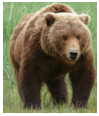

In [51]:
show_image(im.permute(1,2,0));

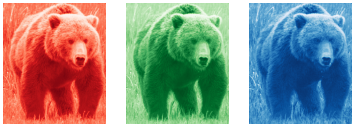

In [52]:
_,axs = plt.subplots(1,3, figsize=(15,10))
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

We have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels.

## Export 

In [55]:
import nbdev; nbdev.nbdev_export()